In [1]:
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense, LSTM
from tqdm.keras import TqdmCallback
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import os
import shutil

C:\Users\Pietro\Anaconda3\envs\tf_gpu\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
# Add the python path to the folder containing some useful custom packages.
import sys
sys.path.insert(0, "../../packages/")
from TsIP.TsIP import TsIP
from rolling_window import rolling_window
from tools import find_multiple_sets

In [3]:
# Create workspace.
dir = "./output"
if not os.path.exists(dir):
    os.makedirs(dir)
else:
    shutil.rmtree(dir)           
    os.makedirs(dir)

In this notebook, I provide an implementation of a **LSTM network** capable to forecast the FCS indicator of each province of the Yemen country using as predictors both the endogenous and the exogenous indicators. The idea of this implementation is to put the data of all province into a single 'pot' for training a single network.

Assuming for example to use a *direct* forecast approach to predict some future values of the FCS time-series (denote it as $Z$). Define $P = \{𝐴𝑏𝑦𝑎𝑛, 𝐴𝑑𝑒𝑛, …, 𝑇𝑎𝑖𝑧𝑧\}$  as the ensemble of all the provinces of the Yemen country: each single province $p$ is described by some own time-series (endogenous and exogenous data sources). $\forall p \in P$, we have:

<img src="./images/direct_forecast.gif" width="700">

Each province will get own set of training points $(\vec{X}^p, \vec{y}^p)$. All this points are put into a single ‘pot’ that feed a single neural network: 

<img src="./images/single.png" width="400">

Finally, using the trained network, we can predict the test set ($z_{17}, z_{18}, z_{19}, z_{20}$) feeding to the network the input:

$z_{12}, z_{13}, z_{14}, z_{15}, z_{16}$

$e_{12}, e_{13}, e_{14}, e_{15}, e_{16}$

$v_{12}, v_{13}, v_{14}, v_{15}, v_{16}$

Unlike other machine learning algorithms, long short-term memory recurrent neural networks (LSTM) are capable of automatically
learning features from sequence data, support multiple-variate data, and can output a variable length sequences that can be used for multi-step forecasting. I'm going to build a network based on LSTM layer. LSTM is useful for time-series prediction beacuse it has memory. How? Through the 'state' of the LSTM layer. It could be 'stateless' (stateful = False) or 'stateful' (stateful = True). 

- **stateless**: in this case, all the states are resetted together after each batch. A batch with 10 sequences would create 10 states, and all 10 states are resetted automatically after it's processed. The next batch with 10 sequences will create 10 new states, which will also be resetted after this batch is processed. So the memory is involved about the various time-steps of each sequence. If all those sequences have length (timesteps) = 7, the practical result of these two batches is: 20 individual sequences, each with length 7. None of the sequences are related. But of course: the weights (not the states) will be unique for the layer, and will represent what the layer has learned from all the sequences. 

    - A state is: Where am I now inside a sequence? Which time step is it? How is this particular sequence behaving since its beginning up to now?
    - A weight is: What do I know about the general behavior of all sequences I've seen so far?
    
- **stateful**: in this case, there is also the same number of parallel states, but they will simply not be resetted at all. A batch with 10 sequences will create 10 states that will remain as they are at the end of the batch. The next batch with 10 sequences (it's required to be 10, since the first was 10) will reuse the same 10 states that were created before. The practical result is: the 10 sequences in the second batch are just continuing the 10 sequences of the first batch, as if there had been no interruption at all. If each sequence has length (timesteps) = 7, then the actual meaning is: 10 individual sequences, each with length 14. When you see that you reached the total length of the sequences, then you call model.reset_states(), meaning you will not continue the previous sequences anymore, now you will start feeding new sequences.

N.B. I will use the LSTM in 'stateless' mode.

## Dataset

In [4]:
PATH_TO_DATA_FOLDER = "../../Dataset time-series/"

In [5]:
# Load the dataset.
train = pd.read_csv(PATH_TO_DATA_FOLDER + "train_smooth.csv", header = [0, 1], index_col = 0)
train.index.name = "Datetime"
train.index = pd.to_datetime(train.index)
freq = "D"
train.index.freq = freq

In [6]:
# Load the dataset.
test = pd.read_csv(PATH_TO_DATA_FOLDER + "test_target.csv", header = [0, 1], index_col = 0)
test.index.name = "Datetime"
test.index = pd.to_datetime(test.index)
freq = "D"
test.index.freq = freq

In [7]:
# Load the dataset.
target = pd.read_csv(PATH_TO_DATA_FOLDER + "all_target.csv", header = [0, 1], index_col = 0)
target.index.name = "Datetime"
target.index = pd.to_datetime(target.index)
freq = "D"
target.index.freq = freq

In [8]:
TEST_SIZE = 30
FREQ = train.index.freq

In [9]:
TRAIN = train.copy()

In [10]:
PROVINCES = TRAIN.columns.get_level_values(0).unique()
PROVINCES

Index(['Abyan', 'Aden', 'Al Bayda', 'Al Dhale'e', 'Al Hudaydah', 'Al Jawf',
       'Al Maharah', 'Al Mahwit', 'Amanat Al Asimah', 'Amran', 'Dhamar',
       'Hajjah', 'Ibb', 'Lahj', 'Marib', 'Raymah', 'Sa'ada', 'Sana'a',
       'Shabwah', 'Taizz'],
      dtype='object', name='AdminStrata')

In [11]:
PREDICTORS = TRAIN.columns.get_level_values(1).unique()
PREDICTORS

Index(['1 Month Anomaly (%) Rainfall', '3 Months Anomaly (%) Rainfall',
       'Cereals and tubers', 'Exchange rate (USD/LCU)', 'FCS', 'Fatality',
       'Lat', 'Lon', 'NDVI Anomaly', 'Population', 'Rainfall (mm)', 'Ramadan',
       'rCSI'],
      dtype='object', name='Indicator')

## Data source transformation

I decide to normalize the data among the provinces considering indicator by indicator and considering only the training sets.

In [12]:
global SCALERS

MIN = 0
MAX = 1
SCALERS = dict()
def normalization(group, feature_range):
    min_, max_ = feature_range
    min_group = group.min().min()
    max_group = group.max().max()
    
    # Normalization.
    group_std = (group - min_group) / (max_group - min_group)
    group_scaled = group_std * (max_ - min_) + min_

    # Save the scalers for the various indicators.
    SCALERS[group.name] = (min_group, max_group)

    return group_scaled

In [13]:
TRAIN_NORMALIZED = TRAIN.groupby(axis = 1, level = 1).apply(lambda x: normalization(x, (MIN, MAX)))
TRAIN_NORMALIZED.head()

AdminStrata                        Abyan                                \
Indicator   1 Month Anomaly (%) Rainfall 3 Months Anomaly (%) Rainfall   
Datetime                                                                 
2018-08-22                      0.215732                      0.334810   
2018-08-23                      0.214827                      0.330565   
2018-08-24                      0.213375                      0.325265   
2018-08-25                      0.211677                      0.319646   
2018-08-26                      0.209939                      0.314103   

AdminStrata                                                                 \
Indicator   Cereals and tubers Exchange rate (USD/LCU)       FCS  Fatality   
Datetime                                                                     
2018-08-22            0.113035                0.097113  0.398652  0.015955   
2018-08-23            0.118731                0.108255  0.417303  0.014210   
2018-08-24            0.121727                0.112477  0.423109  0.014238   
2018-08-25            0.123281                0.113002  0.424826  0.015126   
2018-08-26            0.124426                0.112481  0.427781  0.016268   

AdminStrata                                              ...  \
Indicator         Lat       Lon NDVI Anomaly Population  ...   
Datetime                                                 ...   
2018-08-22   0.204339  0.354998     0.203677   0.137715  ...   
2018-08-23   0.204339  0.354998     0.201767   0.137715  ...   
2018-08-24   0.204339  0.354998     0.199870   0.137715  ...   
2018-08-25   0.204339  0.354998     0.197950   0.137715  ...   
2018-08-26   0.204339  0.354998     0.195990   0.137715  ...   

AdminStrata                   Taizz                                        \
Indicator   Exchange rate (USD/LCU)       FCS  Fatality      Lat      Lon   
Datetime                                                                    
2018-08-22                 0.100691  0.522180  0.124402  0.13656  0.07253   
2018-08-23                 0.105181  0.506301  0.118615  0.13656  0.07253   
2018-08-24                 0.109271  0.495034  0.115735  0.13656  0.07253   
2018-08-25                 0.113148  0.487033  0.115840  0.13656  0.07253   
2018-08-26                 0.116965  0.481466  0.118860  0.13656  0.07253   

AdminStrata                                                          
Indicator   NDVI Anomaly Population Rainfall (mm) Ramadan      rCSI  
Datetime                                                             
2018-08-22      0.317287   0.894478      0.430215     0.0  0.522625  
2018-08-23      0.314277   0.894478      0.436639     0.0  0.513277  
2018-08-24      0.311164   0.894478      0.446466     0.0  0.511028  
2018-08-25      0.307901   0.894478      0.458051     0.0  0.511425  
2018-08-26      0.304470   0.894478      0.470108     0.0  0.512072  

[5 rows x 260 columns]

In [14]:
# Plot time-series.
TsIP(TRAIN_NORMALIZED).interactive_plot_df(title = "Training sets", matplotlib = False, style = "lines")

interactive(children=(ToggleButtons(description='AdminStrata', options=('Abyan', 'Aden', 'Al Bayda', "Al Dhale…

In [15]:
def denormalization(group_scaled, indicator, feature_range, scalers):
    min_, max_ = feature_range
    min_group, max_group = scalers[indicator]

    group_std = (group_scaled - min_) / (max_ - min_)
    group = (group_std * (max_group - min_group)) + min_group
    
    return group

## Training

In [16]:
# Convert history into inputs X and outputs y.
def to_supervised(group, n_input, n_out, target = "FCS"):
    adminstrata = group.name
    freq = group.index.freq
    # Delete level regarding the province information.
    group.columns = group.columns.droplevel()

    serie_to_predict = group[target][n_input:]
    serie_to_predict = serie_to_predict.values
    group = group[:-n_out]
        
    n_features = len(group.columns)
    group = group.values

    # Rolling window over exogenus and endogenous variables.
    X = rolling_window(group, n_input, axes = 0)
    y = rolling_window(serie_to_predict, n_out)
    # Adjust in order to have shape: (n_samples, time-steps, n_features).

    X = X[:y.shape[0]].swapaxes(1, 2)

    return X, y

In [17]:
LAGS = 30

In [18]:
TRAIN_NORMALIZED_SETS = find_multiple_sets(TRAIN_NORMALIZED)

In [19]:
X_train_list, y_train_list = list(), list()
for train_normalized in TRAIN_NORMALIZED_SETS:
    # Create training points.
    data_train = train_normalized.groupby(axis = 1, level = 0).apply(lambda x: to_supervised(x, LAGS, TEST_SIZE, "FCS"))

    # (n_provinces, n_samples, time-steps, n_features)
    X_train = np.stack([d[0] for d in data_train])
    # (n_provinces, n_samples, n_out)
    y_train = np.stack([d[1] for d in data_train])

    n_features = X_train.shape[3]

    # Merge all the provinces. (n_samples, time-steps, n_features)
    X_train = np.concatenate(X_train)
    y_train = np.concatenate(y_train) 

    # Train splits.
    X_train_list.append(X_train)
    y_train_list.append(y_train)

X_train = np.concatenate(X_train_list)
y_train = np.concatenate(y_train_list)

print("Training shape: X:", X_train.shape, "y:", y_train.shape)

Training shape: X: (8240, 30, 13) y: (8240, 30)


In [20]:
def network(timesteps, features, n_out):      
    model = Sequential()

    # MODEL.
    model.add(LSTM(10, return_sequences = False, batch_input_shape = (None, timesteps, features)))

    model.add(Dense(n_out))  

    return model

Training the network:


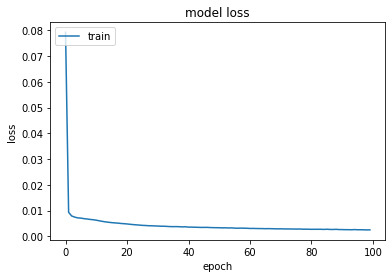

In [22]:
model = network(LAGS, n_features, TEST_SIZE)
# Compile model.
model.compile(loss = "mse", optimizer = "adam")
# Fit model.
print("Training the network:")
history = model.fit(X_train, y_train, epochs = 100, batch_size = 32, verbose = 0, shuffle = True, callbacks = [TqdmCallback(verbose = 1)])

# Plot result of the training and validation.
plt.plot(history.history["loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train"], loc = "upper left")
plt.show()

In [23]:
TEST_TARGET_SETS = find_multiple_sets(test)

In [24]:
FORECASTING_NORMALIZED = test.copy()
# Prediction over the test sets.
for train_set, test_set in zip(TRAIN_NORMALIZED_SETS, TEST_TARGET_SETS):
    # Create input test sample.
    data_test = train_set.groupby(axis = 1, level = 0).apply(lambda group: group.tail(LAGS).values)
    # Prediction for each province.
    for province in PROVINCES:
        X_test = data_test.loc[province]
        X_test = np.expand_dims(X_test, 0)
        # Prediction.
        y_hats = model.predict(X_test, verbose = 0).flatten() 
        # Add the prediction to the dataframe.
        FORECASTING_NORMALIZED[(province, "FCS")].loc[test_set.index] = y_hats

In [25]:
# Denormalization.
FORECASTING = denormalization(FORECASTING_NORMALIZED, "FCS", (MIN, MAX), SCALERS)

In [26]:
forecasting_target_sets = find_multiple_sets(FORECASTING)

In [28]:
from sklearn.metrics import mean_squared_error

# Loss.
loss = np.mean([mean_squared_error(test_set, forecasting_set) for test_set, forecasting_set in zip(TEST_TARGET_SETS, forecasting_target_sets)])
loss

29.976595359672434

In [29]:
# Plot time-series.
TsIP(FORECASTING, target).interactive_plot_df(title = "Forecasting", matplotlib = False, style = "lines", comparison = True)

interactive(children=(RadioButtons(description='Select:', options=('Time-series', 'Missing values'), value='Ti…